## PART I
A workflow for inference on the presence of a target object using an MRF. We designed a toy problem to validate whether target object inference matched our intuitions based on simulated co-occurrence statistics. We intend to compare the output of an exact inference algorithm to the manual calcuation of energy. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import VariableElimination, BeliefPropagation, ApproxInference
from pgmpy.sampling import GibbsSampling
import daft
import random
import itertools

c:\Users\karae\anaconda3\envs\vrrl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[0.  0.5 1.  0.2]
 [0.5 0.  0.2 0.1]
 [1.  0.2 0.  1. ]
 [0.2 0.1 1.  0. ]]


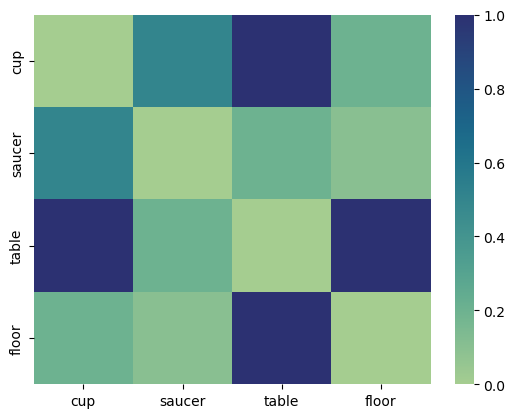

In [3]:
objects = ["cup","saucer","table","floor"]

# counts
cooccur = np.array([[0,5,10,2],
                    [5,0,2,1],
                    [10,2,0,10],
                    [2,1,10,0]])

cooccur = cooccur/np.max(cooccur)

print(cooccur)
sns.heatmap(cooccur,xticklabels=objects,yticklabels=objects,cmap='crest')

#np.fill_diagonal(cooccur,0)
cooccur = pd.DataFrame(cooccur,index=objects,columns=objects)


In [4]:
# instantiate network
G = MarkovNetwork()

# create graph (add nodes and edges)
nodes = objects
edges = list(itertools.combinations(objects,r=2))

G.add_nodes_from(nodes)
G.add_edges_from(edges)

<Axes:>

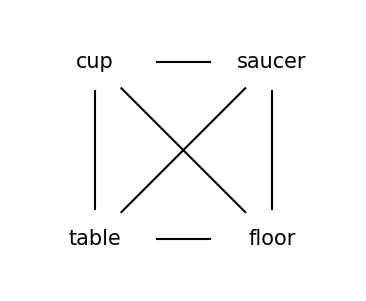

In [5]:
# illustrate graph
pgm = daft.PGM(aspect=2.1, dpi=150, node_unit=1, grid_unit=3, directed=False, node_ec=None)

x = [0, 1, 0, 1]
y = [1, 1, 0, 0]

for i in range(len(nodes)):
    pgm.add_node(nodes[i], nodes[i], x[i], y[i])
    
for i in range(len(edges)):    
    pgm.add_edge(edges[i][0],edges[i][1])
    
pgm.render()

In [6]:
# phi based on Kollar & Roy 2009
def compatibility(edge,cooccur):
    
    tt = cooccur.loc[edge[0],edge[1]] / np.sum(cooccur.loc[edge[0],:])
    ft = (np.sum(cooccur.loc[:,edge[1]])-cooccur.loc[edge[0],edge[1]]) / (np.sum(np.triu(np.asarray(cooccur)))-np.sum(cooccur.loc[edge[0],:]))
    tf = 1 - tt
    ff = 1 - ft

    phi = np.reshape([ff, ft, tf, tt],(2,2))
    
    return phi

In [7]:
# create factors
for e in G.edges():
    factor = DiscreteFactor(e, [2, 2], compatibility(e,cooccur))
    G.add_factors(factor)

In [8]:
def mrf_approx_infer(nodes, cooccur, evidence={}, iterations=1000):

    # total energy calculation
    E = np.zeros(iterations)

    # pregenerate states
    S = pd.DataFrame(np.random.randint(low = 0, high = 2, size = (iterations,len(nodes))),columns = nodes)

    if (len(evidence) > 0):
        for idx, key in enumerate(list(evidence.items())):
            S[key[0]] = key[1]

    # start iterations loop
    for i in range(iterations):
        
        state = S.iloc[i]
        energy = []
        edges = list(itertools.combinations(nodes,r=2))

        for e in range(len(edges)):
        
            psi = compatibility(edges[e],cooccur)[state[edges[e][0]],state[edges[e][1]]]
            energy.append(psi)

        E[i] = np.sum(np.log(energy))

    return S.iloc[np.argmax(E)] # print state with maximum energy 


In [88]:
def mrf_exact_infer(nodes, evidence={}, iterations=1000):

    G_infer = BeliefPropagation(G)
    node_states = pd.DataFrame(np.zeros((1,len(nodes))),index=['state'],columns=nodes)
    
    for i in range(len(list(evidence.keys()))):
        node_states[list(evidence.keys())[i]] = list(evidence.values())[i]
        nodes.remove(list(evidence.keys())[i])

    for n in nodes:
        G_prob = G_infer.query(variables=[n], evidence=evidence)
        node_states[n] = np.argmax((G_prob.values))

    return node_states.T

In [10]:
# mrf exact inference with package
nodes = objects.copy()
evidence = {'saucer': 1}

mrf_exact_infer(nodes,evidence)

        state
cup         1
saucer      1
table       0
floor       0


In [11]:
# mrf approximate inference custom
nodes = objects.copy()
evidence = {'saucer': 1}

mrf_approx_infer(nodes,cooccur,evidence) 

cup       1
saucer    1
table     0
floor     0
Name: 11, dtype: int64

## PART II
 
Below attempts another toy problem with additional objects to verify custom algorithm.

In [101]:
all_objs = pd.read_excel('post_objects.xlsx')
full_objects = []
n = 10

for i in range(n):
    full_objects.append(all_objs.iloc[i][0][6:])

<AxesSubplot:>

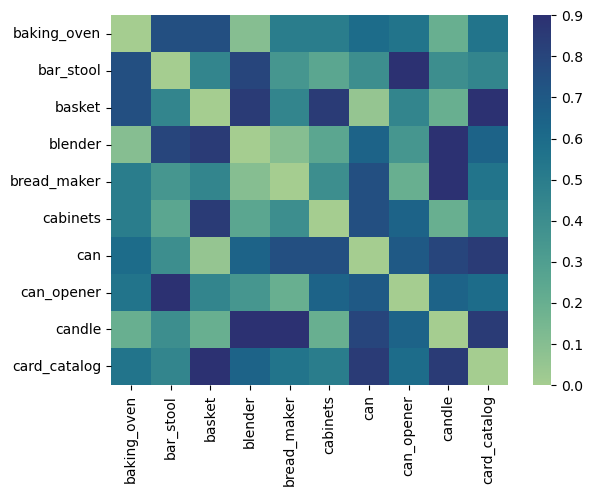

In [102]:
# counts
cooccur = np.random.randint(low=1,high=21,size=(len(full_objects),len(full_objects)))
np.fill_diagonal(cooccur,0)
cooccur = cooccur/np.max(cooccur)
cooccur = np.tril(cooccur)
cooccur = np.maximum(cooccur, cooccur.transpose())
cooccur = pd.DataFrame(cooccur,index=full_objects,columns=full_objects)

sns.heatmap(cooccur,cmap='crest')

In [103]:
# instantiate network
G = MarkovNetwork()

# create graph (add nodes and edges)
nodes = full_objects.copy()
edges = list(itertools.combinations(full_objects,r=2))

G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [104]:
# create factors
for e in G.edges():
    factor = DiscreteFactor(e, [2, 2], compatibility(e,cooccur))
    G.add_factors(factor)

In [116]:
# mrf exact inference with package
nodes = full_objects.copy()
temp = mrf_exact_infer(nodes)

In [127]:
np.asarray(temp.T)[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [140]:
# MRF APPROXIMATE INFERENCE

# list of nodes
nodes = full_objects.copy()
instances = 100

# data storage
state_exact = np.zeros((instances,len(nodes)))
state_approx = np.zeros((instances,len(nodes)))

for i in range(instances):
    
    # create random evidence for inference
    nodes = full_objects.copy()
    evidence = {key: np.random.randint(low=0,high=2,size=1)[0] for key in random.sample(nodes,np.random.randint(low=0,high=len(nodes)+1))}
    
    state_exact[i,:] = np.asarray((mrf_exact_infer(nodes,evidence)).T)
    state_approx[i,:] = np.asarray((mrf_approx_infer(nodes,cooccur,evidence,iterations=10000).T)) 

In [149]:
err = 0

for i in range(instances):
    
    err += np.sum(state_exact[i,:] - state_approx[i,:])

In [151]:
# MRF APPROXIMATE INFERENCE

# list of nodes
nodes = full_objects.copy()
instances = 10

# data storage
state_exact = np.zeros((instances,len(nodes)))
state_approx = np.zeros((instances,len(nodes)))

for i in range(instances):
    print(i)
    
    # create random evidence for inference
    nodes = full_objects.copy()
    evidence = {key: np.random.randint(low=0,high=2,size=1)[0] for key in random.sample(nodes,np.random.randint(low=0,high=len(nodes)+1))}
    
    state_exact[i,:] = np.asarray((mrf_exact_infer(nodes,evidence)).T)
    state_approx[i,:] = np.asarray((mrf_approx_infer(nodes,cooccur,evidence,iterations=100000).T)) 

0


In [81]:
nodes = full_objects.copy()
evidence = {'candle': 1, 'chair': 1}
node_states = pd.DataFrame(None,columns=['objects','states'])
node_states['objects'] = nodes
node_states['states'] = np.zeros((len(nodes),1))
    
for i in list(evidence.keys()):
    node_states.loc[node_states['objects'] == i,'states'] = evidence[i]
    nodes.remove(i)

start_state = list(zip(node_states.objects, node_states.states))


ValueError: list.remove(x): x not in list

In [ ]:
gibbs = GibbsSampling(G)
gen = gibbs.sample(start_state=start_state,size=100)

In [610]:
start_state

[('baking_oven', 0.0),
 ('bar_stool', 0.0),
 ('basket', 0.0),
 ('blender', 0.0),
 ('bread_maker', 0.0),
 ('cabinets', 0.0),
 ('can', 0.0),
 ('can_opener', 0.0),
 ('candle', 1.0),
 ('card_catalog', 0.0),
 ('cereal_bowl', 0.0),
 ('chair', 1.0),
 ('cinnamon', 0.0),
 ('cloth', 0.0),
 ('coffee_maker', 0.0)]

## PART III
Below attempts the custom approximate inference algorithm on a larger (i.e., a more realistic number) set of objects to test how long it takes to run.

In [321]:
all_objs = pd.read_excel('post_objects.xlsx')
full_objects = []

for i in range(len(all_objs)):
    full_objects.append(all_objs.iloc[i][0][6:])

In [322]:
# counts
cooccur = np.random.randint(low=1,high=21,size=(len(full_objects),len(full_objects)))
np.fill_diagonal(cooccur,0)
cooccur = cooccur/np.max(cooccur)
cooccur = pd.DataFrame(cooccur,index=full_objects,columns=full_objects)

In [301]:
# mrf approximate inference custom
iterations = 10
nodes = full_objects.copy()
evidence = {'baking_oven': 1}

mrf_approx_infer(nodes,cooccur,evidence,iterations)

(baking_oven       1
 bar_stool         1
 basket            1
 blender           1
 bread_maker       1
                  ..
 trash_can         1
 tub               0
 vanity_case       0
 wash_cloth        1
 window_curtain    0
 Name: 7, Length: 97, dtype: int64,
 -8289.056137141104)

## PART IV

recode toy problem using mrf2d package in R

In [32]:
import os
import numpy as np
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.2.0'
os.environ['R_USER'] = 'C:/Users/karae/anaconda3/envs/vrrl/lib/site-packages/rpy2'

import rpy2
from rpy2.robjects.packages import importr
import rpy2.ipython.html
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.robjects.vectors import StrVector, ListVector, IntVector


rpy2.ipython.html.init_printing()


In [27]:
# Choosing a CRAN Mirror
utils = importr('utils')
base = importr('base')
utils.chooseCRANmirror(ind=1)

# utils.install_packages()

# import packages
mrf2d = importr('mrf2d')

In [36]:
interact = mrf2d.mrfi(max_norm = 1)

In [38]:
interact

<rpy2.robjects.methods.RS4 object at 0x000001D20DB62BC0> [RTYPES.S4SXP]
R classes: ('mrfi',)